# Deep Learning Project

The current project relies on using CNNs in order to process sperm data. The goal is to develop a classifier able to identify sperm cells.

The model is not yet fuly defined. We will start with a standard CNN to Dense Layer.

The goal is for images to be loaded into the CNN. The CNN will will then perform feature extraction and those will be fed to the final model.

In [1]:
#import some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import matplotlib.image as mpimg
%matplotlib inline

#image manipulation packages
import cv2
import os
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

sns.set()
#import keras
from tensorflow import keras

## Step 1 - Create the pipeline

The Deep learning model will be made out of 2 different parts: 

1. A CNN that takes the images as inputs and performs feature extraction.
2. A dense, fully connected layer that will perform classification itself with the features.

In [2]:
def image_cnn_model():
    '''creates an image classification model that uses 2 Convolutional CNNs layers (with maxpooling) and feeds the data through
    a dense connected layer. This is trial and error there is no specific reason for 2 layers'''
    cnn_model = keras.Sequential([

        #convolutional layer with 24 3x3 filters - again, arbitrary,
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'), 

        #MaxPooling - takes the max value of each 2x2 pool in the feature map
        keras.layers.MaxPool2D(pool_size=(2,2)),

        #second convolution with 36 filters
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation= 'relu'),
    
        #Second MaxPool2D - to check with other options
        keras.layers.MaxPool2D(pool_size=(2,2)),
        
        #the result of kthe CNN is then flattened and placed into the 
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        
        keras.layers.Dense(256, activation='relu'),
        
        #final layer, is output, 1 out of 5 possible results
        #0 Normal, 1 Tapered, 2 Pyriform, 3 Small, 5 Amorphous
        keras.layers.Dense(5, activation='softmax')
    ])
    
    return cnn_model

# Step 2: Load the Data

In this case, we have a folder with 1132 image - SCIAN-MorphoSpermGS folder - https://cimt.uchile.cl/gold10/. Each image is 35 x 35 pixels and has been classified by 3 experts. We will use majority vote result as target. Each image will need to be loaded and the dataset will need to be created.

#### This will yield a dataset with the picture name and the label.

In [3]:
#1 - load txt file
sperm = 'Sperm'
dataframe = pd.read_csv(r'C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\SCIAN-MorphoSpermGS\PA-expert-annotations.txt', sep = '\\t', header = None)
dataframe

<ipython-input-3-5e8176a9e611>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataframe = pd.read_csv(r'C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\SCIAN-MorphoSpermGS\PA-expert-annotations.txt', sep = '\\t', header = None)


,0,1,2,3,4
0,p1-pl2-sample01/Sperm_01,5,5,5,5
1,p1-pl2-sample01/Sperm_02,1,5,5,5
2,p1-pl2-sample01/Sperm_03,0,0,0,0
3,p1-pl2-sample01/Sperm_04,1,5,5,5
4,p1-pl2-sample01/Sperm_05,0,0,0,0
...,...,...,...,...,...
1127,p5-pl1-sample20/Sperm_07,1,5,5,5
1128,p5-pl1-sample20/Sperm_09,1,1,5,1
1129,p5-pl1-sample20/Sperm_11,1,1,5,1
1130,p5-pl1-sample20/Sperm_12,5,5,5,5


In [4]:
#editions to target dataset
dataframe.rename(columns={0 :"Sperm_Pic", 1: 'Expert_1', 2: 'Expert_2', 3: 'Expert_3', 4: 'Majority_Vote'}, inplace = True)
dataframe['Sperm_Pic'] = dataframe['Sperm_Pic'].str.replace('/S', '-s')
dataframe['Majority_Vote'] = dataframe['Majority_Vote'].replace(5, 4)


#add ch_00 to all rows:
dataframe['Sperm_Pic'] = 'ch00_' + dataframe['Sperm_Pic'] + '.tif'

#Drop all irrelevant features
dataframe = dataframe.drop(['Expert_1', 'Expert_2', 'Expert_3'], axis = 1)

#Show
dataframe

,Sperm_Pic,Majority_Vote
0,ch00_p1-pl2-sample01-sperm_01.tif,4
1,ch00_p1-pl2-sample01-sperm_02.tif,4
2,ch00_p1-pl2-sample01-sperm_03.tif,0
3,ch00_p1-pl2-sample01-sperm_04.tif,4
4,ch00_p1-pl2-sample01-sperm_05.tif,0
...,...,...
1127,ch00_p5-pl1-sample20-sperm_07.tif,4
1128,ch00_p5-pl1-sample20-sperm_09.tif,1
1129,ch00_p5-pl1-sample20-sperm_11.tif,1
1130,ch00_p5-pl1-sample20-sperm_12.tif,4


In [20]:
dataframe['Majority_Vote'].value_counts()

4    656
1    228
0    100
2     76
3     72
Name: Majority_Vote, dtype: int64

## Step 3 - Create dataset from folder of images

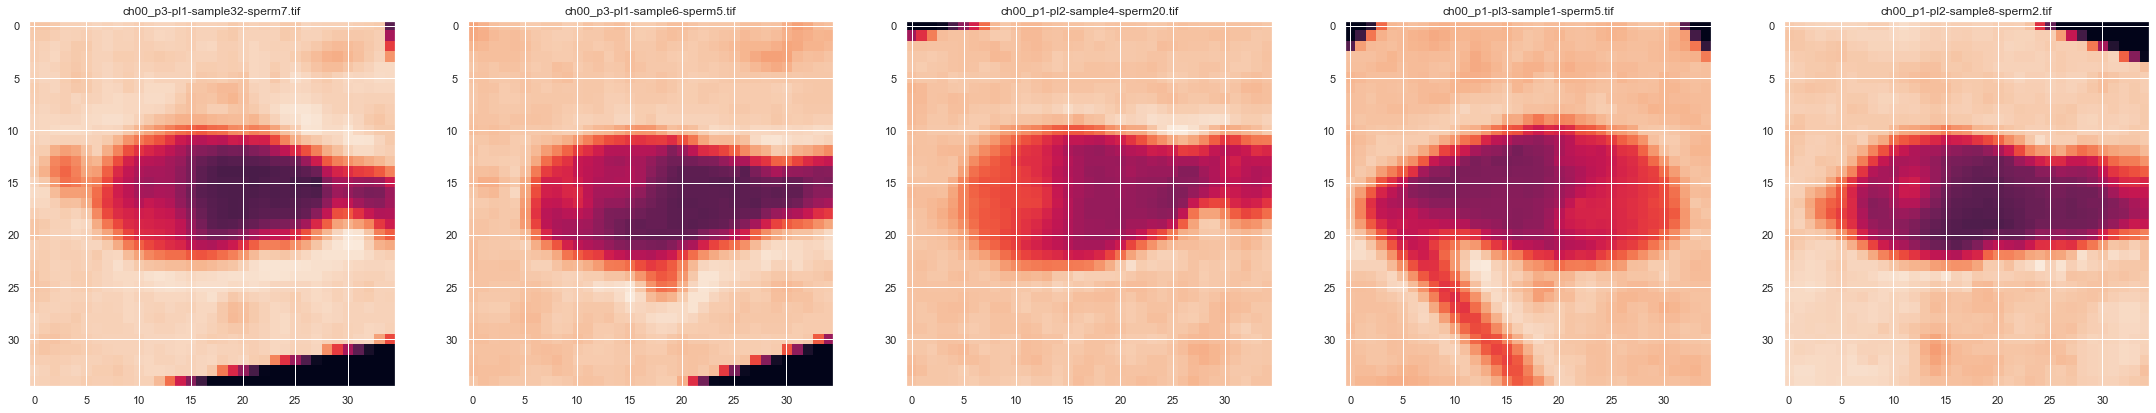

In [5]:
#Small test to print last 5 pics

plt.figure(figsize=(38,38))

test_folder=r'C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\SCIAN-MorphoSpermGS\Partial-Agreement-Images'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [6]:
def create_dataset(img_folder):
   
    img_data_array=[]
    
    for file in os.listdir(os.path.join(img_folder)):
        
        image_path= os.path.join(img_folder, file)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (38, 38),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
    
    return img_data_array# extract the image array and class name
img_data = create_dataset(test_folder)
img_data

[array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.03921569, 0.        ,
         0.        ],
        ...,
        [0.64705884, 0.654902  , 0.6392157 , ..., 0.6745098 , 0.6666667 ,
         0.6666667 ],
        [0.65882355, 0.654902  , 0.6431373 , ..., 0.6745098 , 0.65882355,
         0.6627451 ],
        [0.654902  , 0.63529414, 0.6313726 , ..., 0.6666667 , 0.6666667 ,
         0.6666667 ]], dtype=float32),
 array([[0.63529414, 0.61960787, 0.61960787, ..., 0.        , 0.        ,
         0.        ],
        [0.62352943, 0.61960787, 0.62352943, ..., 0.        , 0.        ,
         0.        ],
        [0.6313726 , 0.627451  , 0.627451  , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.5372549 , 0.5137255 , 0.53333336, ..., 0.6313726 , 0.627451  ,
         0.6313726 

## Compile and try to get model working

Initialize Model, Compile and perform split. 

In [7]:
labels = np.array(dataframe['Majority_Vote'])
labels = np.array(np.split(labels, 1132))

In [8]:
#train_test_split to get 20% of data as test

X_train_val, X_test, y_train_val, y_test = train_test_split(img_data,
                                                  labels,
                                                  test_size = 0.20,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=labels)

In [9]:
#convert everything into nd arrays
X_train_val, X_test, y_train_val, y_test = np.array(X_train_val), np.array(X_test), np.array(y_train_val), np.array(y_test)

In [10]:
#Need to reshape input to tell Conv2D there is only one feature map
X_train_val1 = X_train_val.reshape(X_train_val.shape + (1,))
print(X_train_val1.shape) 

(905, 38, 38, 1)


In [11]:
#Need to reshape input of test to tell Conv2D there is only one feature map
X_test1 = X_test.reshape(X_test.shape + (1,))
print(X_test1.shape)

(227, 38, 38, 1)


In [12]:
#train_test_split to get 20% of data as test

X_train, X_val, y_train, y_val = train_test_split(X_train_val1,
                                                  y_train_val,
                                                  test_size = 0.10,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=y_train_val)

In [13]:
#compile model: First try
cnn_model = image_cnn_model()

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping criteria
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Epoch 1/50
82/82 [==============================] - 2s 19ms/step - loss: 1.3022 - accuracy: 0.5729 - val_loss: 1.2520 - val_accuracy: 0.5824
Epoch 2/50
82/82 [==============================] - 1s 9ms/step - loss: 1.2968 - accuracy: 0.5590 - val_loss: 1.2006 - val_accuracy: 0.5824
Epoch 3/50
82/82 [==============================] - 1s 9ms/step - loss: 1.2602 - accuracy: 0.5524 - val_loss: 1.2327 - val_accuracy: 0.5824
Epoch 4/50
82/82 [==============================] - 1s 9ms/step - loss: 1.2150 - accuracy: 0.5972 - val_loss: 1.2201 - val_accuracy: 0.5824
Epoch 5/50
82/82 [==============================] - 1s 8ms/step - loss: 1.2329 - accuracy: 0.5724 - val_loss: 1.1998 - val_accuracy: 0.5824
Epoch 6/50
82/82 [==============================] - 1s 9ms/step - loss: 1.2075 - accuracy: 0.5735 - val_loss: 1.1991 - val_accuracy: 0.5824
Epoch 7/50
82/82 [==============================] - 1s 9ms/step - loss: 1.2051 - accuracy: 0.5906 - val_loss: 1.2063 - val_accuracy: 0.5824
Epoch 8/50
82/82 [=

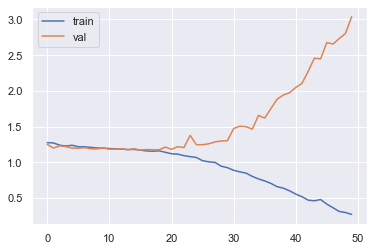

In [14]:
#fit model
history = cnn_model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=10, epochs=50, verbose = 1)

# evaluate the model
_, train_acc = cnn_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = cnn_model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [15]:
#Performance do primeiro teste

test_loss, test_acc = cnn_model.evaluate(X_test1, y_test)

print('Test accuracy:', test_acc)

8/8 [==============================] - 0s 5ms/step - loss: 2.9608 - accuracy: 0.4758
Test accuracy: 0.4757709205150604


### Base performance is pretty bad - 56%

Let's try and improve it with bruteforce Hyperparam optimization whiole being on the lookout for other ways to improve performance.